In [58]:
# data processing
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# regression / matching
import statsmodels.formula.api as smf

## Load the data

In [66]:
data_path = "DATA/"

mex_df = pd.read_csv(data_path+"Mex_daily_edac.txt", sep='\t')
mex_offset_df = pd.read_csv(data_path+"MeX_EDAC_offset.txt", sep='\t')
nac_df = pd.read_csv(data_path+"Nac_daily_edac.txt", sep='\t')
ndm_df = pd.read_csv(data_path+"Ndm_daily_edac.txt", sep='\t')
ros_nac_offset_df = pd.read_csv(data_path+"Ros_AOCS_NAC_offset.txt", sep='\t')
ros_ndm_offset_df = pd.read_csv(data_path+"Ros_AOCS_NDM_offset.txt", sep='\t')
vex_df = pd.read_csv(data_path+"VEX_NDMW0D0A_2023_01_11_12_55_55.900.txt", sep='\t')
vex_boundary_df = pd.read_csv(data_path+"VEX-ICME-boundaries.csv")

## Venus Express data

In [67]:
#vex_df['DATE_TIME'] = vex_df.DATE_TIME.apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f')) #takes more time for the graphs to show
vex_df.set_index('DATE_TIME', inplace=True)
display(vex_df.head())

,NDMW0D0A
DATE_TIME,
2005-11-09 00:09:04.575,0
2005-11-09 00:10:08.575,0
2005-11-09 00:11:12.576,0
2005-11-09 00:12:16.576,0
2005-11-09 00:13:20.577,0


In [68]:
vex_df.iloc[0]

NDMW0D0A    0
Name: 2005-11-09 00:09:04.575, dtype: int64

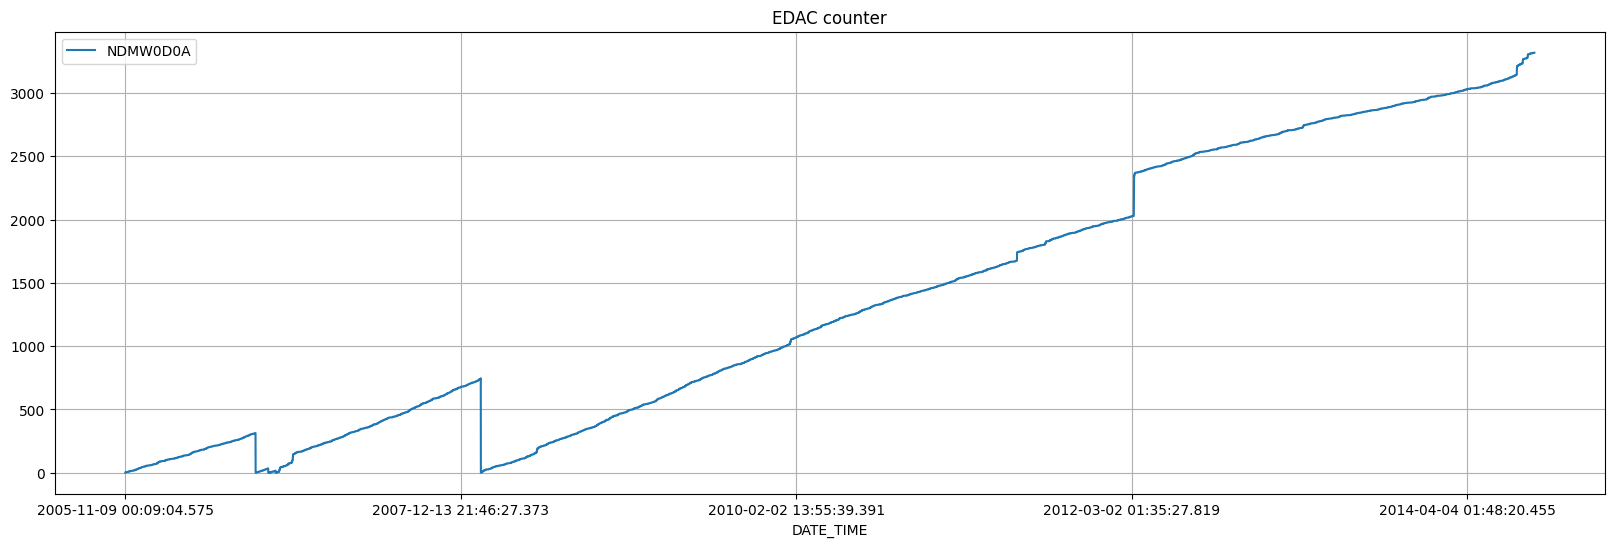

In [69]:
vex_df.plot(kind='line', figsize=(20,6))
plt.title('EDAC counter')
plt.grid()
plt.show()

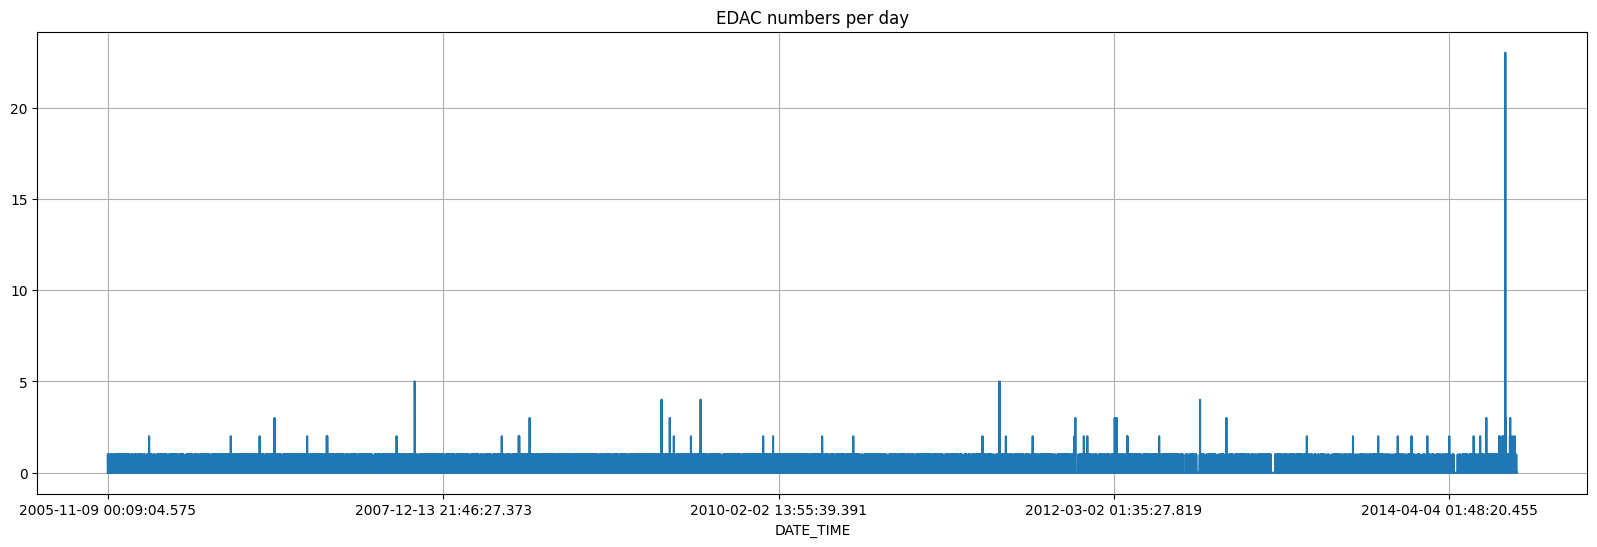

In [70]:
vex_df['EDAC'] = vex_df['NDMW0D0A'].diff().bfill().astype(int).map(lambda x: max(0, x))

vex_df['EDAC'].plot(kind='line', figsize=(20,6))
plt.title('EDAC numbers per day')
plt.grid()
plt.show()

Now let's visualize on top of this plot the events of CME :

In [71]:
cme_df = pd.read_csv(data_path+"CME_date_time.csv")

In [72]:
vex_df['cme'] = 0

for index, row in cme_df.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    
    # Set 'cme' column values to 1 between start_time and end_time
    vex_df.loc[(vex_df.index >= start_time) & (vex_df.index <= end_time), 'cme'] = 1

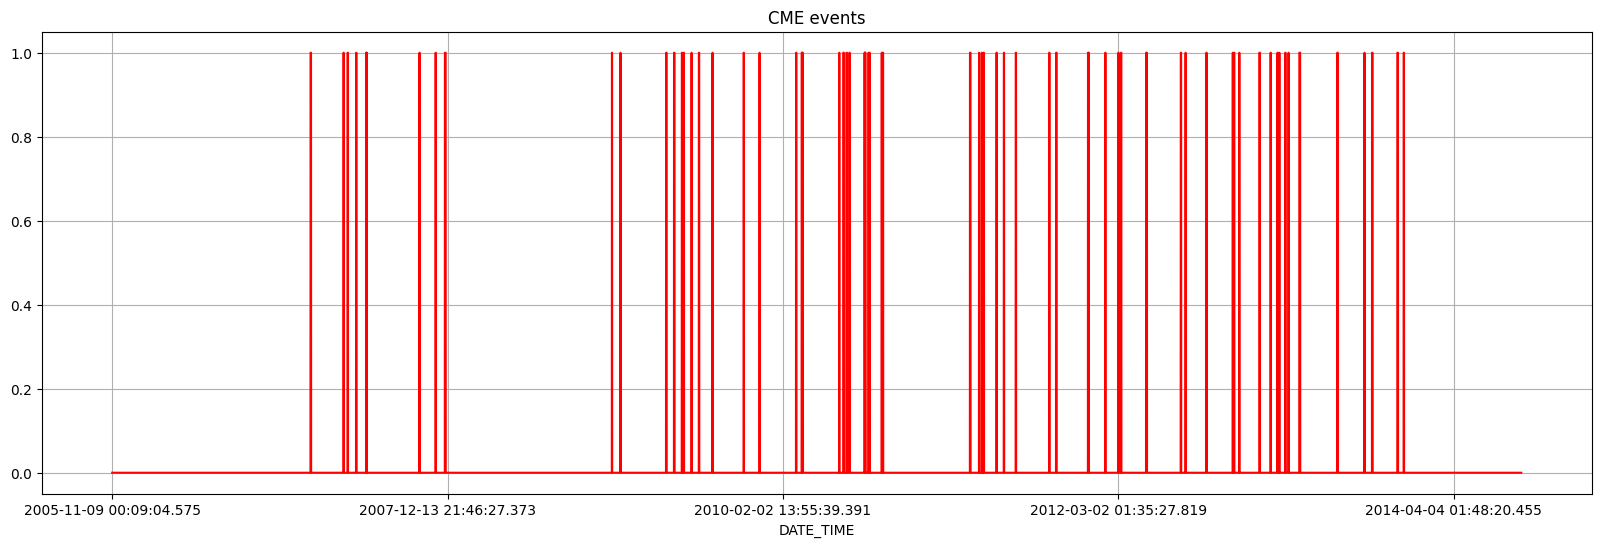

In [73]:
vex_df['cme'].plot(kind='line', figsize=(20,6), color='red')
plt.title('CME events')
plt.grid()
plt.show()

In [74]:
#start_array = cme_df['start_time'].values
vex_df['EDAC'] = vex_df['NDMW0D0A'].diff().bfill().astype(int).map(lambda x: max(0, x))

### Looking at EDAC and CME evants

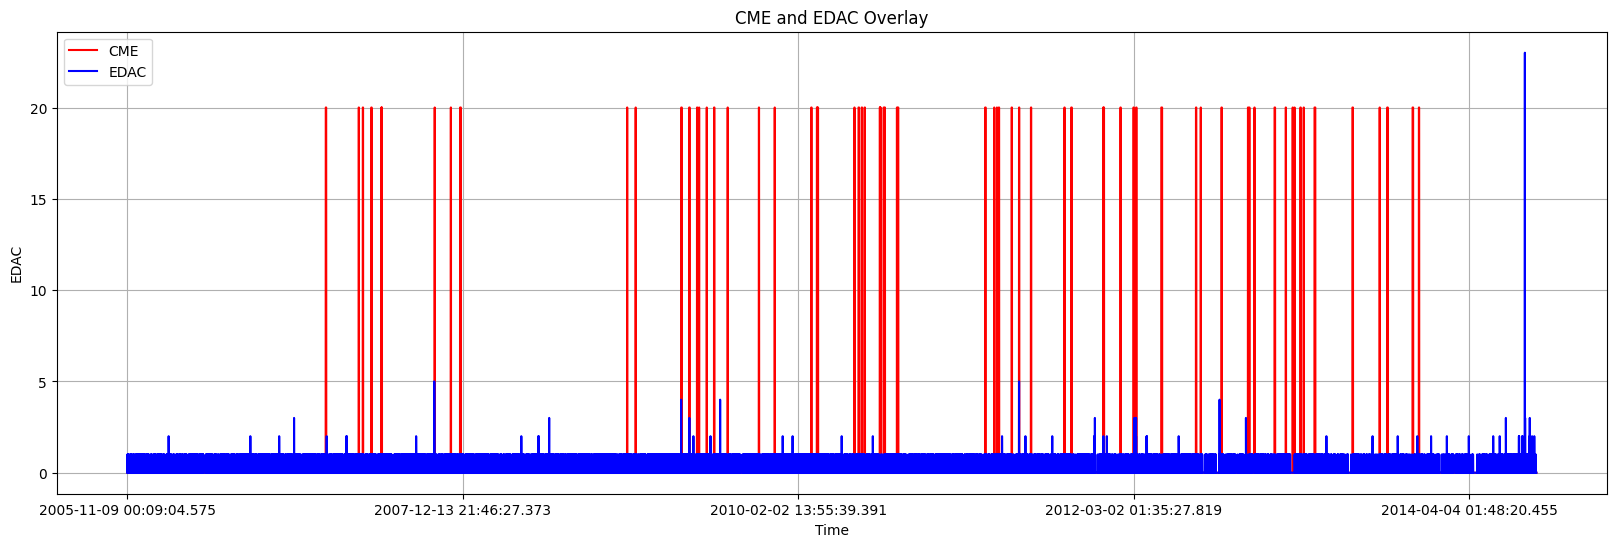

In [75]:
fig, ax = plt.subplots(figsize=(20, 6))

# Plot 'cme'
(vex_df['cme']*20).plot(kind='line', color='red', label='CME')

# Plot 'EDAC' on top of 'cme'
vex_df['EDAC'].plot(kind='line', color='blue', label='EDAC')

ax.set_xlabel('Time')
ax.set_ylabel('EDAC')

plt.title('CME and EDAC Overlay')
plt.grid()
plt.legend()
plt.show()

We can also look at the EDAC counter (sum) :

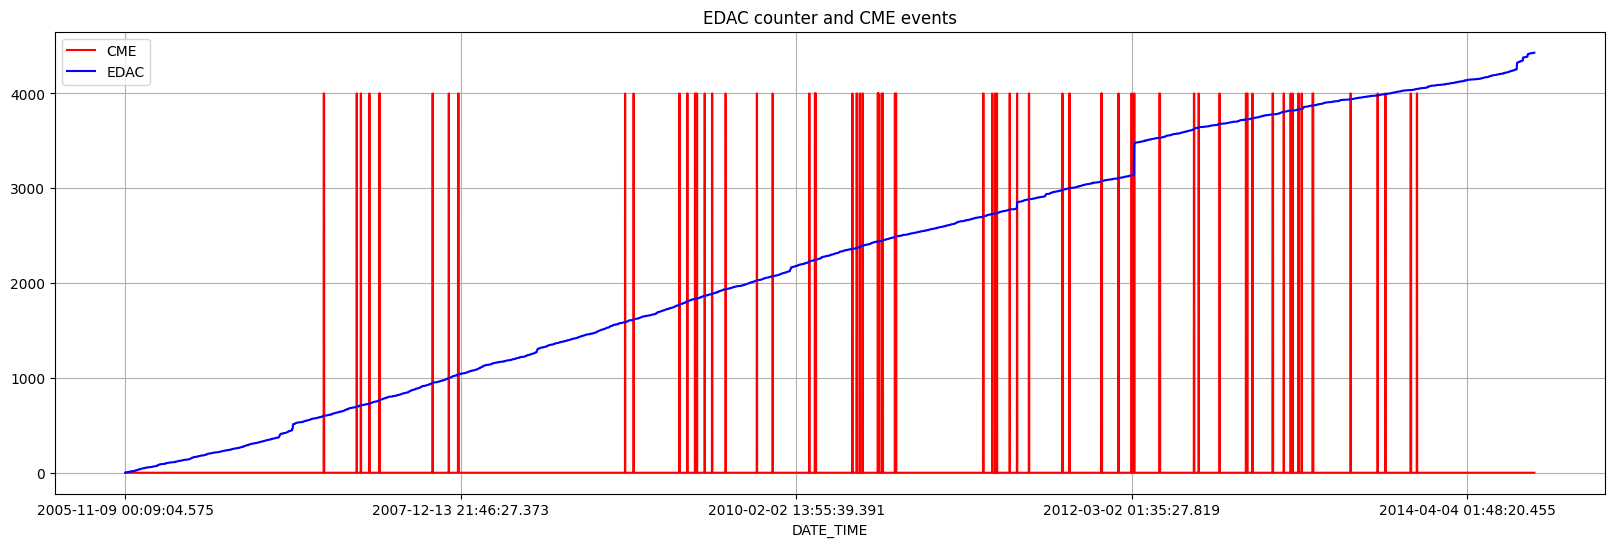

In [76]:
vex_df['EDAC_counter'] = vex_df['EDAC'].cumsum()

fig, ax = plt.subplots(figsize=(20, 6))
(vex_df['cme']*4000).plot(kind='line', color='red', label='CME')
vex_df['EDAC_counter'].plot(kind='line',color='blue', label='EDAC')

plt.title('EDAC counter and CME events')
plt.grid()
plt.legend()
plt.show()